# Visualizing Activation from a CNN

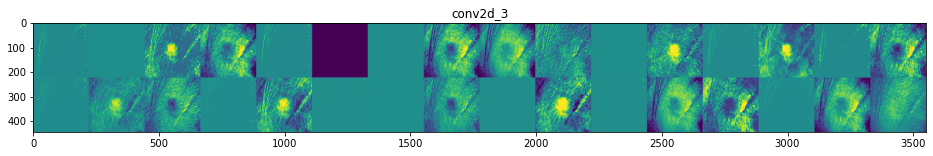

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

In [ ]:
# load libraries
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)
    
reset_random_seeds()

from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import models
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

## Load Data

In [ ]:
#https://www.kaggle.com/ibtesama/siim-baseline-keras-vgg16
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
train.head()

In [ ]:
train = train[train['diagnosis'] != 'unknown']
train['diagnosis'].value_counts()

In [ ]:
train = train[train['diagnosis'] != 'atypical melanocytic proliferation']
train['diagnosis'].value_counts()

In [ ]:
train = train[train['diagnosis'] != 'cafe-au-lait macule']
train['diagnosis'].value_counts()

## Preprocess images

In [ ]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['diagnosis'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['diagnosis']=labels

test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

X_train, X_val, y_train, y_val = train_test_split(df['images'],df['diagnosis'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['diagnosis']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['diagnosis']=y_val

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=256,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='diagnosis',
    target_size=(224, 224),
    shuffle=False,
    batch_size=256,
    class_mode='categorical')

## Build Convnet

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(6, activation='softmax'))
model.summary()

## Train Convnet

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fit = model.fit(train_generator, epochs=2, validation_data=validation_generator)

## Evaluate Convnet

In [ ]:
metrics = list(fit.history.keys())
loss_values = fit.history[metrics[2]]
val_loss_values = fit.history[metrics[0]]
acc_values = fit.history[metrics[3]]
val_acc_values = fit.history[metrics[1]]
print("\nFinal validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()